<a href="https://colab.research.google.com/github/skhanna95/anomaly-detection-kmeans/blob/master/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
X, label_cluster = make_blobs(100, centers = 1)

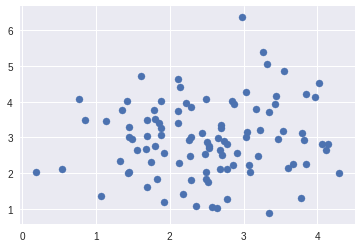

In [23]:
plt.scatter(X[:, 0], X[:, 1], s=50);

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=1)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

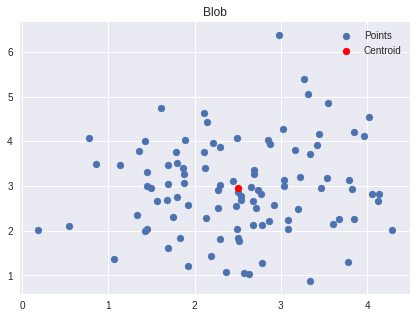

In [25]:
f, ax = plt.subplots(figsize=(7,5))
ax.set_title('Blob')
ax.scatter(X[:, 0], X[:, 1], label='Points')
ax.scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 1], label='Centroid',
           color='r')
ax.legend(loc='best')

In [0]:
# identify the 10 closest points
outlier_distances = kmeans.transform(X)

In [0]:
# argsort returns an array of indexes which will sort the array
# in ascending order. Reverse it with [::-1]
indices = np.argsort(outlier_distances.ravel())[::-1][:10] #ravel Returns a contiguous flattened array which is needed for getting indices.




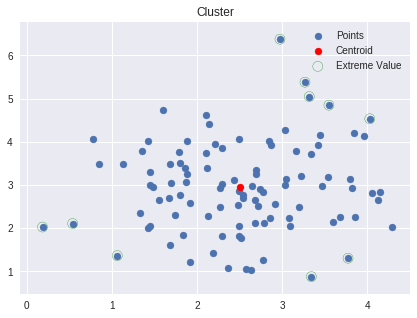

In [28]:
f, ax = plt.subplots(figsize=(7,5))
ax.set_title('Cluster')
ax.scatter(X[:, 0], X[:, 1], label='Points')
ax.scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 1],
           label='Centroid', color='r')
ax.scatter(X[indices][:, 0],
           X[indices][:, 1],
           label='Extreme Value', edgecolors='g',
           facecolors='none', s=100)
ax.legend(loc='best')

In [0]:
# simulating removing these outliers
X_improved = np.delete(X, indices, axis=0)

In [30]:
# this causes the centroids to move slightly
Kmeans_improved = KMeans(n_clusters=1)
Kmeans_improved.fit(X_improved)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

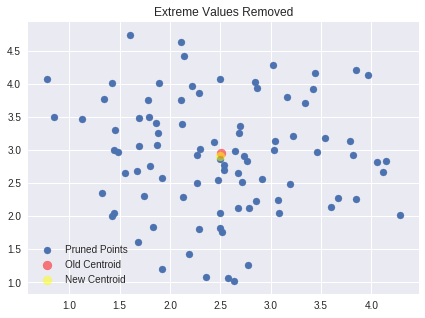

In [31]:
f, ax = plt.subplots(figsize=(7,5))
ax.set_title("Extreme Values Removed")
ax.scatter(X_improved[:, 0], X_improved[:, 1], label='Pruned Points')
ax.scatter(kmeans.cluster_centers_[:, 0],
           kmeans.cluster_centers_[:, 1],
           label='Old Centroid',
           color='r', s=80, alpha=.5)
ax.scatter(Kmeans_improved.cluster_centers_[:, 0],
           Kmeans_improved.cluster_centers_[:, 1],
           label='New Centroid',
           color='yellow', s=80, alpha=.5)
ax.legend(loc='best')

In [32]:
# There is a fundamental connection between Gaussian distribution
# and the KMeans clustering. Let's create an empirical Gaussian
# based off the centroid and sample covariance matrix and look
# at the probability of each point that we removed.
# this will show that the points we removed were the least likely
# to occur.
from scipy import stats
emp_dist = stats.multivariate_normal(kmeans.cluster_centers_.ravel())
prob_indices = np.argsort(emp_dist.pdf(X))[:10]
np.all(X[indices] == X[prob_indices])

True

In [33]:
print (kmeans.cluster_centers_)
print (kmeans.cluster_centers_.ravel())



[[2.50665172 2.95439652]]
[2.50665172 2.95439652]


let us take an example to see this

Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any a priori label information.

In [34]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:


In [35]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster. Let's see what these cluster centers look like:

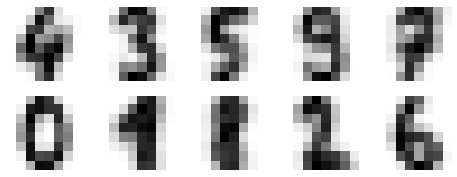

In [36]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the true labels found in them:


In [0]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

<font color="blue" face="comic sans ms">With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let's check the confusion matrix for this:</font>

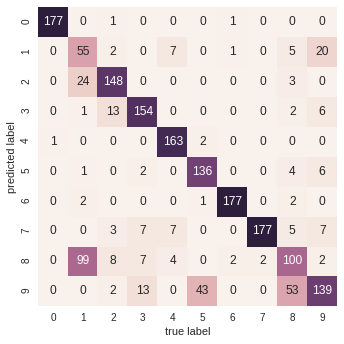

In [39]:
import seaborn as sns; sns.set()  # for plot styling
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');



As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels!

We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm to pre-process the data before performing k-means. t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters. Let's see how it does:

In [40]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9326655537006121

93% accuracy is amazingly good!

(427, 640, 3)


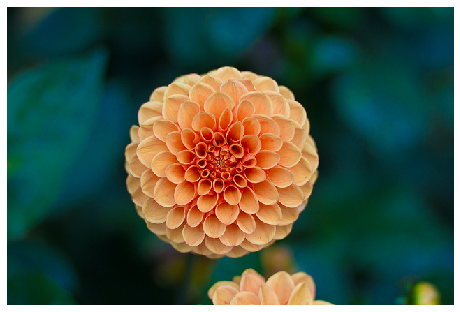

In [51]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);
print(flower.shape)

In [52]:
new_shape = flower / 255.0 # use 0...1 scale
new_shape = new_shape.reshape(427 * 640, 3)
new_shape.shape

(273280, 3)

In [0]:
def plot_pixels(pixel_val, title, colors=None, N=10000):
    if colors is None:
        colors = pixel_val
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(new_shape.shape[0])[:N]
    colors = colors[i]
    R, G, B = new_shape[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

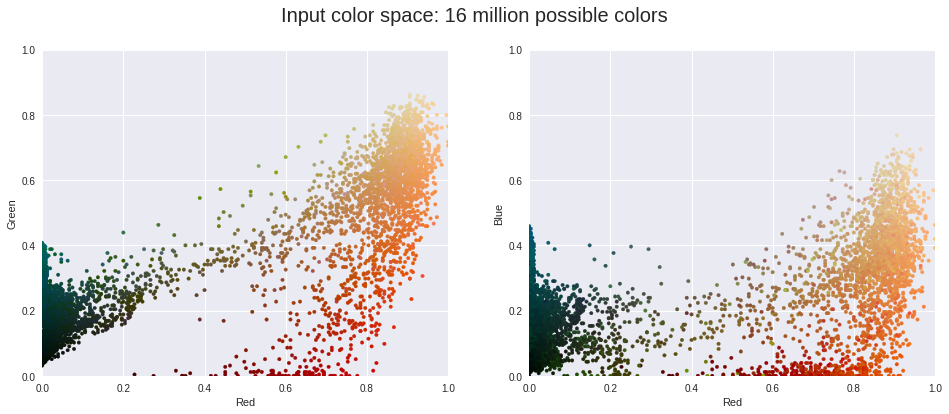

In [59]:
plot_pixels(new_shape, title='Input color space: 16 million possible colors')


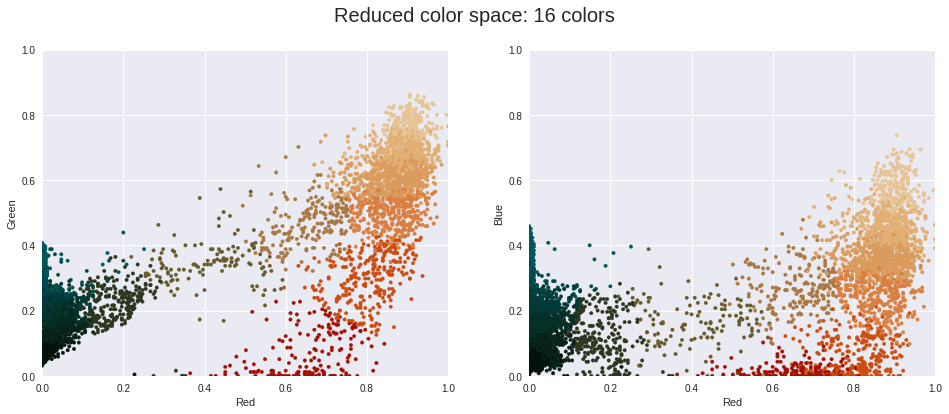

In [62]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(new_shape)
new_colors = kmeans.cluster_centers_[kmeans.predict(new_shape)]

plot_pixels(new_shape, colors=new_colors,
            title="Reduced color space: 16 colors")

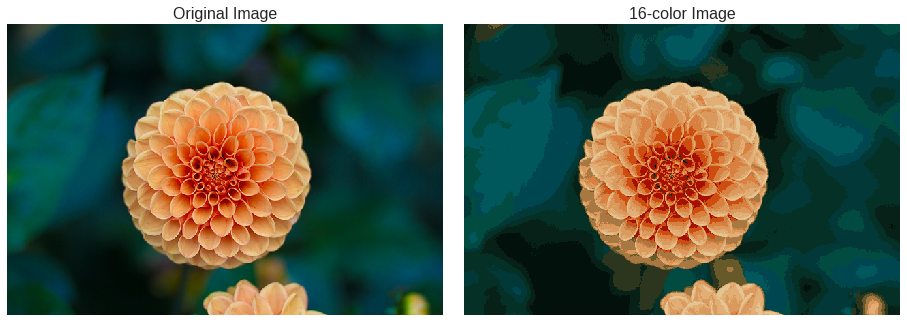

In [63]:
flower_decompressed = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_decompressed)
ax[1].set_title('16-color Image', size=16);